# Fix the method

The goal of this notebook is to analyze the iterative method and see that it makes sence. 


## Are the equations correct? 

By the equations I mean the 2 correction terms:

$$
        V_r = \hat{V_r}+  \frac{V_z \mu \cdot( \vec{R_0} \times \hat{e_z}) + DV_z\mu \cdot(\hat{n} \times \hat{e_z})}{\mu \cdot (\vec{R_0} \times \hat{n}) }
$$

and most importantly the distance:

$$
            D = \frac{ V_z \hat{n} \cdot ( \vec{R_0} \times \hat{e_z}) )  - \hat{n} \cdot ( \vec{R_0 \times} \vec{V_0})}{\hat{n} \cdot(\vec{R_0} \times \vec{\mu})} = \hat{D_I} + \frac{ V_z \hat{n} \cdot ( \vec{R_0} \times \hat{e_z}) ) }{\hat{n} \cdot(\vec{R_0} \times \vec{\mu})}

$$

We can test this with simulated ejections, lets try it with speedystar objects

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.correction_non_radial.iterative_correction import compute_R0xez
from scripts.correction_non_radial.iterative_correction import compute_ez
from scripts.correction_non_radial.iterative_correction import compute_R0_V0_SI
from scripts.correction_non_radial.iterative_correction import getdist_corrected
#from scripts.catalog_preparation.prepare_gaia import prepare_speedystar

In [2]:
# load some data to test
from astropy.table import Table


# lets test with some speedystar data
data = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits')

In [3]:
data = data[data['v0']> 1500]

In [4]:
data

r0,phi0,theta0,v0,phiv0,thetav0,m,tage,tflight,sep,P,q,mem,met,stage,stagebefore,Rad,T_eff,Lum,vx,vy,vz,x,y,z,ra,dec,dist,par,pmra,pmdec,vlos,Lz,b,l,pmb,pml,Vesc,GCdist,GCv,thetaf,phif,Av,Bessell_V,Bessell_I,Gaia_GRVS,Gaia_G,Gaia_BP,Gaia_RP,e_par,e_pmra,e_pmdec,e_vlos
float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3.0,2.756798064142757,2.4151080972265357,4077.458123851052,2.756798064142757,2.4151080972265357,0.5812422014970259,2570.193209766919,47.35469596803641,2.8580605479643504,0.46097008858956945,0.650920348068256,2.0,0.0,0.0,1.0,0.5410165916048679,4017.7043456402453,0.06871138532308671,-2458.7530364171853,995.7529447877538,-2976.7667761360663,-119.3250015874385,48.324585656895785,-144.4789749163644,323.6482130544891,-27.415682095842417,198.56260110864747,0.005036195106312241,0.15868655671886495,-0.20025913343086915,3926.890671217243,-4.0248796586528604e-10,-46.557155230135145,20.727743761840937,-0.19542055633339575,-0.1646084747761132,281.534940305183,193.51458801763837,3987.2460245953876,2.4137405997439934,2.756798064142758,0.09682020038366318,30.16579071176148,28.55201374506774,28.249072772795493,29.601627614458394,30.40959991103885,28.721600824058665,2842.508997811411,1648.6552187306183,1421.2544989057055,--
3.0,2.9732296241447904,0.010538986091825154,3036.9800450812504,2.9732296241447904,0.010538986091825154,0.6034956164187659,3714.9626483298807,30.62071857043448,1.9694851504513697,0.33894529051934436,0.47846630763109654,1.0,0.0,0.0,0.0,0.5653348256995598,4090.4027350024644,0.08060674742450719,-30.464729186267586,5.1781536434143725,2921.898395810067,-0.9582034258919652,0.1628678374449882,91.9237267755142,197.90390977292793,24.178247201165203,92.3386370077968,0.01082970284600977,-0.7975010837513407,-0.08766281848808877,2902.373468923186,3.709327991667134e-15,84.58064862587607,1.0710367555850835,0.6117157944428849,-0.5191305569497413,349.2750059189082,91.92886502093481,2922.0617975048017,0.010573006361840423,2.97322962414479,0.04274179865157125,28.202933109086572,26.676539525318677,26.386098337574627,27.68526253367044,28.445907381351404,26.836384974662298,486.6270825703718,282.24370789081564,243.3135412851859,--
3.0,4.577147367468163,1.2459868689631297,1653.8083538433111,4.577147367468163,1.2459868689631297,0.6451941076234676,8104.9151474667415,76.63408357693758,13.332187693886375,4.940363223483478,0.9811465002687288,2.0,0.0,0.0,0.0,0.6150844849186269,4278.337421839202,0.1141997926892822,-183.43698584792176,-1348.0854281495513,431.27887818924165,-14.636701041921217,-107.56567602541068,34.551696995965806,165.83356575053304,-40.93181485252957,115.2179575422639,0.008679202628923386,-0.3140233552797376,0.00551207252196885,1636.307528651245,-4.772687292072099e-11,17.470309539598926,281.8384614983853,-0.12814145102419955,-0.2867417289723357,329.6950192934031,113.92290130388719,1427.2298063515561,1.2626527498140294,-1.7060379397114236,0.4707915263175641,28.554428082934045,27.020098635743665,26.724831833448093,28.028933917045766,28.802713707100807,27.171724600376844,667.8079492146148,387.32861054447653,333.9039746073074,--
3.0,3.4446500005567846,0.7739690916764265,2418.3518904588595,3.4446500005567846,0.7739690916764265,0.5206631587581961,2083.314011930752,40.104497306270304,1.5929845332790102,0.28794127401692027,0.25648298724636553,1.0,0.0,0.0,0.0,0.4795025008117796,3867.953065610764,0.04636627141879461,-1522.7709140690151,-476.1542205356365,1617.6645000660021,-62.91227014187068,-19.671995751142966,66.8748692740158,222.73765941393916,-10.636833566759389,99.42335767817104,0.010057998677101162,-0.5808805750961958,-0.2108097229849426,2301.2128358053524,7.72798

### Recompute proper motions from cartesian coordinates

We are doing this to make sure that there are no errors, so just starting from the x, y, z and vx, vy, vz that comes from the galpy ejections

In [5]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactocentric
import astropy.units as u





coords = Galactocentric(x = data['x']*u.kpc, y = data['y']*u.kpc, z = data['z']*u.kpc,
                    v_x = data['vx']*u.km/u.s, v_y = data['vy']*u.km/u.s, v_z = data['vz']*u.km/u.s)

icrs_coord = coords.transform_to(coord.ICRS())

In [6]:
data['ra_clean'] = icrs_coord.ra.degree
data['dec_clean'] = icrs_coord.dec.degree
data['pmra_clean'] = icrs_coord.pm_ra_cosdec
data['pmdec_clean'] = icrs_coord.pm_dec
data['radial_velocity'] = icrs_coord.radial_velocity

Since we know the true Vz we can test if the true distance can be obtained from the equations as proposed. If this is the case we should be able to get the distance based on a single iteration of the method if we are using this true pmra, pmdec, and vz.

In [7]:
icrs_coord.pm_ra_cosdec.to(u.rad/u.s)

<Quantity [ 4.83230413e-17, -1.27096911e-16, -3.76262173e-17, ...,
           -4.69659097e-17,  2.87194433e-16,  4.84299264e-17] rad / s>

In [8]:
ra_rad = icrs_coord.ra.rad
dec_rad = icrs_coord.dec.rad
pmra_rad_s = icrs_coord.pm_ra_cosdec.to(u.rad/u.s).value
pmdec_rad_s = icrs_coord.pm_dec.to(u.rad/u.s).value
vz = data['vz']
l = data['l']
b = data['b']

In [9]:

vz_decomp = data['vz'] - data['z']*((data['vx']**2 + data['vy']**2)**0.5 )/(data['x']**2 + data['y']**2)**0.5

In [10]:
VGCR, VR, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, vz_decomp, l, b)

In [11]:
Darr*u.m.to(u.kpc)

array([188.7060808 ,  92.18231026, 110.92380856, ..., 123.56231384,
        32.290484  , 163.37153929])

In [12]:
icrs_coord.distance

<Distance [188.63076105,  92.18185329, 113.16006002, ..., 123.13457096,
            31.80343076, 162.12190399] kpc>

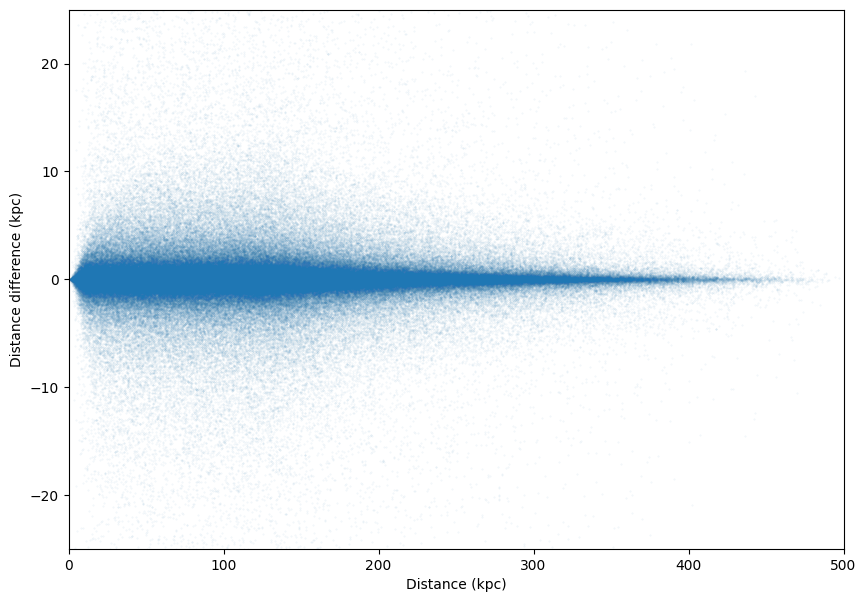

In [13]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(icrs_coord.distance,icrs_coord.distance.value - Darr*u.m.to(u.kpc), s= 0.1, alpha = 0.1)
ax.set_ylim(-25, 25)
ax.set_xlim(0, 500)
ax.set_ylabel('Distance difference (kpc)')
ax.set_xlabel('Distance (kpc)')
plt.show()

Good, it kind of works with the known Vz, now we have to test if the interpolator gives the correct Vz or a new correction is needed. 

In [14]:
from scipy.interpolate import RegularGridInterpolator
import pickle

with open('/Users/mncavieres/Documents/2024-2/HVS/Data/vz_interpolator/vz_rf_vr_sergey_v2.pkl', 'rb') as f:
#with open('/Users/mncavieres/Documents/2024-2/HVS/Data/vz_interpolator/vz_rf_vr_sergey_extrapolate.pkl', 'rb') as f:
    interpolator_vz = pickle.load(f)

In [15]:


# get the galactocentric distance
R_gc = (data['x']**2 + data['y']**2 + data['z']**2)**0.5

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = data['z']/R_gc # Vz/R*VR
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array

vz_rvr = interpolator_vz(points) # Vzf/Rf*
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz = vz_rvr * V_r_sergey/R_gc
vz = vz * 1000 # convert to m/s


In [16]:
vz

nan
nan
-152890.54673995625
-334532.70966657804
nan
-185704.7193174599
nan
nan
nan
nan
nan


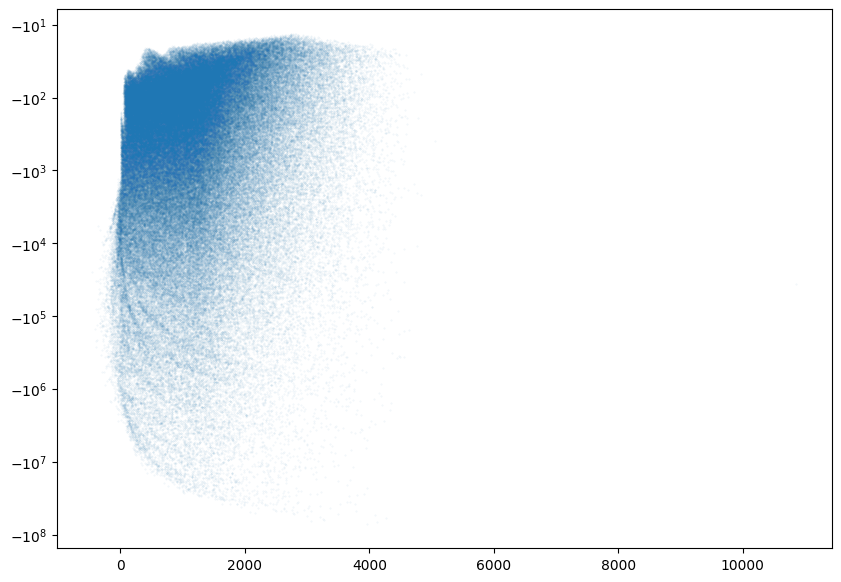

In [17]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(data['vz'], vz/1000, s= 0.1, alpha = 0.1)
ax.set_yscale('symlog')
plt.show()

# Focus on a single source

In [18]:
source_id = 125
ra_rad = icrs_coord.ra.rad[source_id:source_id+1]
dec_rad = icrs_coord.dec.rad[source_id:source_id+1]
pmra_rad_s = icrs_coord.pm_ra_cosdec.to(u.rad/u.s).value[source_id:source_id+1]
pmdec_rad_s = icrs_coord.pm_dec.to(u.rad/u.s).value[source_id:source_id+1]
vz = data['vz'][source_id:source_id+1]
l = data['l'][source_id:source_id+1]
b = data['b'][source_id:source_id+1]
dist = icrs_coord.distance[source_id:source_id+1]


In [19]:
# decompose vz

vz_decomp = data['vz'] - data['z']*data['vx']/data['x']

In [20]:
VGCR, VR, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, vz_decomp[source_id:source_id+1], l, b)

In [21]:
Darr*u.m.to(u.kpc)

array([125.82285886])

In [22]:
dist

<Distance [125.46398426] kpc>

In [23]:

# get the galactocentric distance
R_gc = (data['x']**2 + data['y']**2 + data['z']**2)**0.5

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = data['z']/R_gc # Vzf/Rf*VRf
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array


In [24]:
vz_rvr = interpolator_vz(points[source_id]) # Vzf/Rf*VRf, where VR = sqrt(vx^2 + vy^2) * R / sqrt(x^2 + y^2)
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = R_gc*((data['vx']**2 + data['vy']**2)**0.5)/(data['x']**2 + data['y']**2)**0.5       #data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz = vz_rvr*V_r_sergey/ V_r_sergey
vz = vz * 1000 # convert to m/s

In [25]:
points[source_id]

array([ 2.08862615, -0.77747241])

In [97]:
interpolator_vz(points[source_id])

array([nan])

In [ ]:
vz_decomp = v

# No speedy star, just Gala ejections

In [27]:
import gala.potential as gp
import gala.integrate as gi
import gala.dynamics as gd
import astropy.units as auni
import astropy.coordinates as acoo
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import sys
import os

pot = gp.MilkyWayPotential2022()
kms = auni.km / auni.s

acoo.galactocentric_frame_defaults.set('latest')


def doit(vej, cosang, t):
    #cosang = np.cos(ang)
    #sinang = np.sin(ang)
    sinang = np.sqrt(1 - cosang**2)
    startpos = np.array([cosang, 0, sinang]) *0.001* auni.kpc
    vel = np.array([cosang, 0, sinang]) * vej
    w0 = gd.PhaseSpacePosition(startpos, vel=vel * kms)
    nsteps = 10000
    timestep = t * auni.Myr / nsteps
    orbit = gp.Hamiltonian(pot).integrate_orbit(
        w0,
        dt=timestep,
        n_steps=nsteps,
        Integrator=gi.DOPRI853Integrator,
        # Integrator_kwargs = dict(atol=1e-15,rtol=1e-15)
    )
    R = (orbit.x**2 + orbit.z**2 + orbit.y**2)**.5
    z = orbit.z.to_value(auni.kpc)
    VR = orbit.v_x * R / orbit.x # this is some decomposition of the velocity in a weird way vxR/x
    Vz = orbit.v_z - orbit.v_x * orbit.z / orbit.x
    return R.to_value(auni.kpc), z, VR.to_value(kms), Vz.to_value(kms), orbit.x.to_value(auni.kpc), orbit.y.to_value(auni.kpc), orbit.z.to_value(auni.kpc), orbit.v_x.to_value(kms), orbit.v_y.to_value(kms), orbit.v_z.to_value(kms)


def doall(N=10000, seed=3):
    rng = np.random.default_rng(seed)
    vej = 10**rng.uniform(2.8, 3.5, size=N)
    cosa = rng.uniform(0, 1, size=N)
    times = 100
    r1, r2, r3, r4, c1, c2, c3, v1, v2, v3 = [], [], [], [], [], [], [], [], [], []
    for curv, curc in tqdm(zip(vej, cosa), total=N):
        R, z, VR, Vz, x, y, z, vx, vy, vz = doit(curv, curc, times)
        r1.append(R)
        r2.append(z)
        r3.append(VR)
        r4.append(Vz)
        c1.append(x)
        c2.append(y)
        c3.append(z)
        v1.append(vx)
        v2.append(vy)
        v3.append(vz)
    

    return [np.array(_) for _ in [r1, r2, r3, r4, c1, c2, c3, v1, v2, v3]]

print('Starting')
# Do the simulation
R, z, VR, Vz, x, y, z, vx, vy, vz = doall(100, 3)

Starting


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 20.11it/s]


In [28]:
import pandas as pd

In [29]:
# save orbits
#gala_orbits_small = pd.DataFrame({'R': R.flatten, 'z': z, 'VR': VR, 'Vz': Vz, 'x': x, 'y': y, 'z': z, 'vx': vx, 'vy': vy, 'vz': vz}).to_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/orbits/gala_ejections/orbits_small.csv', index=False)

In [30]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactocentric
import astropy.units as u




coords_gala = Galactocentric(x = x*u.kpc, y = y*u.kpc, z = z*u.kpc,
                    v_x = vx*u.km/u.s, v_y = vy*u.km/u.s, v_z = vz*u.km/u.s)

icrs_coord_gala = coords_gala.transform_to(coord.ICRS())

In [31]:
source_id = 125
ra_rad = icrs_coord_gala.ra.rad.flatten()
dec_rad = icrs_coord_gala.dec.rad.flatten()
pmra_rad_s = icrs_coord_gala.pm_ra_cosdec.to(u.rad/u.s).value.flatten()
pmdec_rad_s = icrs_coord_gala.pm_dec.to(u.rad/u.s).value.flatten()
#vz = data['vz'][source_id:source_id+1]
# make l and b just zeros
l = np.zeros_like(ra_rad.flatten())#data['l'][source_id:source_id+1]
b = np.zeros_like(ra_rad.flatten()) #data['b'][source_id:source_id+1]
dist = icrs_coord_gala.distance.flatten()

In [32]:
VGCR_new, VR_new, Darr =  getdist_corrected(ra_rad, dec_rad, pmra_rad_s, pmdec_rad_s, Vz.flatten(),l , b)

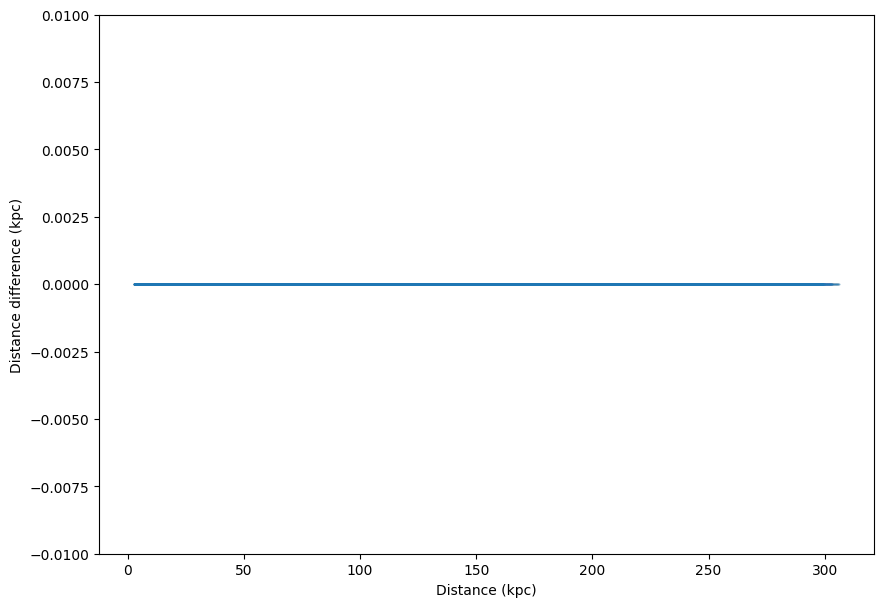

In [33]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(dist, dist.value- Darr*u.m.to(u.kpc), s= 0.1, alpha = 0.1)
ax.set_ylim(-0.01, 0.01)
ax.set_ylabel('Distance difference (kpc)')
ax.set_xlabel('Distance (kpc)')
plt.show()

# Now using the interpolator

In [34]:
# compute Vz from the interpolator

# get the galactocentric distance
R_gc = ((x**2 + y**2 + z**2)**0.5).flatten()

# interpolate to get vz/r*vr
logR = np.log10(R_gc)
ratios = z.flatten()/R_gc # Vzf/Rf*VRf
points = np.array([logR, ratios]).T  # Combine logR and z/R_gc into a single array


In [35]:
vz_rvr = interpolator_vz(points) # Vzf/Rf*VRf, where VR = sqrt(vx^2 + vy^2) * R / sqrt(x^2 + y^2)
#vz_rvr = interpolator_vz(logR, z/R_gc)

V_r_sergey = R_gc*(((vx**2 + vy**2)**0.5)/(x**2 + y**2)**0.5  ).flatten()     #data['vx']* R_gc/data['x'] #VR = orbit.v_x * R / orbit.x, this corresponds to a non-orthogonal decomposition of the velocity in radial and vz components
vz_interpolated = vz_rvr*R_gc/ V_r_sergey.flatten()
#vz = vz * 1000 # convert to m/s

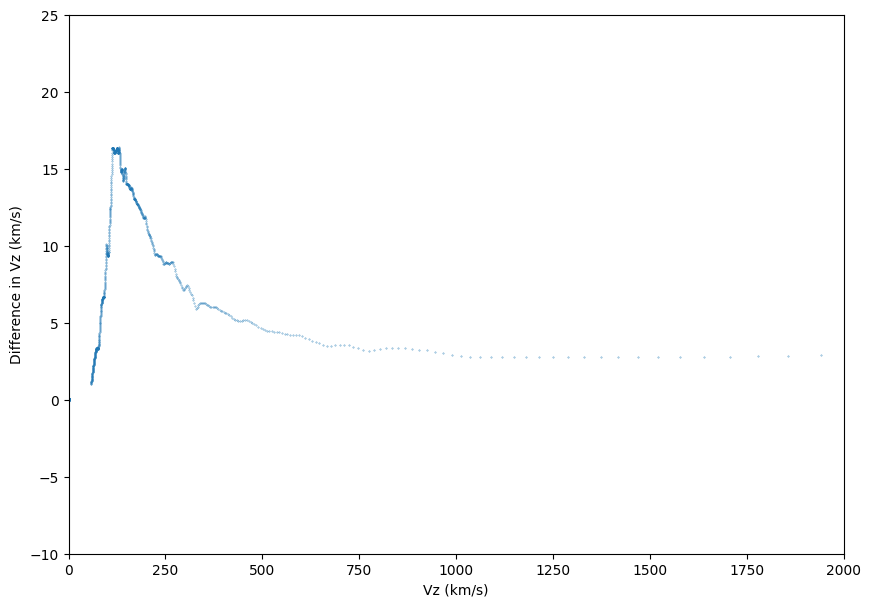

In [143]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(Vz.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000) , s= 0.1, alpha = 0.8)
ax.set_ylim(-10, 25)
#ax.plot([-2000, 2000], [0, 0], 'k--', alpha = 0.6)
ax.set_xlim(0, 2000)
#ax.set_yscale('symlog') 
ax.set_ylabel('Difference in Vz (km/s)')
ax.set_xlabel('Vz (km/s)')
plt.show()

# Compensating bias


In [118]:
x_1 = Vz.flatten()
y_1 = np.abs(vz_interpolated - x_1/1000)
mask = np.isfinite(x_1) & np.isfinite(y_1) & (y_1 < 20) & (y_1 > 2) & (x_1 > 50) & (x_1 < 1000)

poly_vz = np.polyfit(x_1[mask], y_1[mask], 5)

# fit the vz- Vz relation to get the correction using a polynomial fit
#poly_vz = np.polyfit(Vz.flatten(), vz_interpolated - Vz.flatten()/1000, 1)

x_plt = np.linspace(0, 2000, 1000)
y_plt = np.polyval(poly_vz, x_plt)

fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(Vz.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000) , s= 0.1, alpha = 0.8)
ax.plot(x_plt, y_plt, 'k--')
ax.vlines(50, 0, 25, 'r', alpha = 0.5)
ax.set_ylim(0, 25)
ax.set_xlim(0, 2000)
ax.set_ylabel('Difference in Vz (m/s)')
ax.set_xlabel('Vz (m/s)')
plt.show()


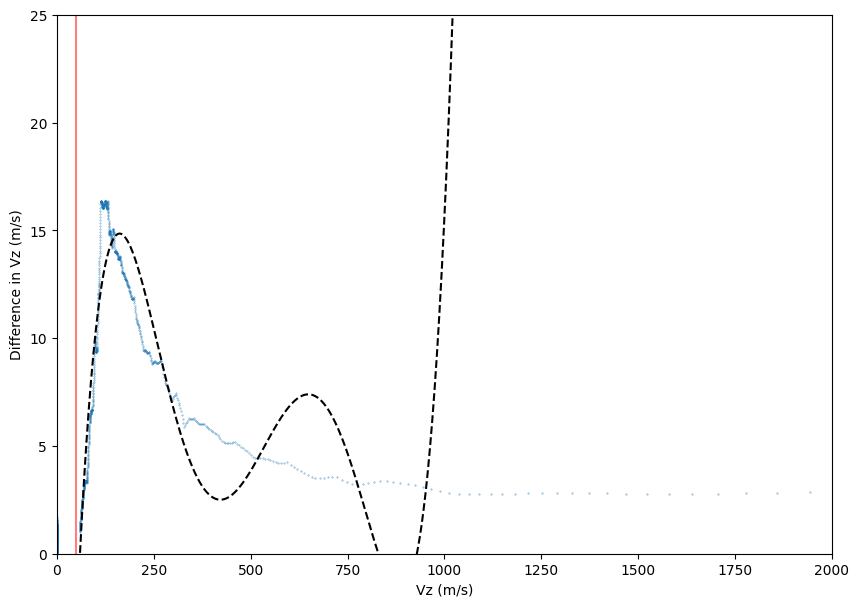

In [119]:
# fit the vz- Vz relation to get the correction using a polynomial fit
#poly_vz = np.polyfit(Vz.flatten(), vz_interpolated - Vz.flatten()/1000, 1)

x_plt = np.linspace(0, 2000, 1000)
y_plt = np.polyval(poly_vz, x_plt)

fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(Vz.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000) , s= 0.1, alpha = 0.8)
ax.plot(x_plt, y_plt, 'k--')
ax.vlines(50, 0, 25, 'r', alpha = 0.5)
ax.set_ylim(0, 25)
ax.set_xlim(0, 2000)
ax.set_ylabel('Difference in Vz (m/s)')
ax.set_xlabel('Vz (m/s)')
plt.show()

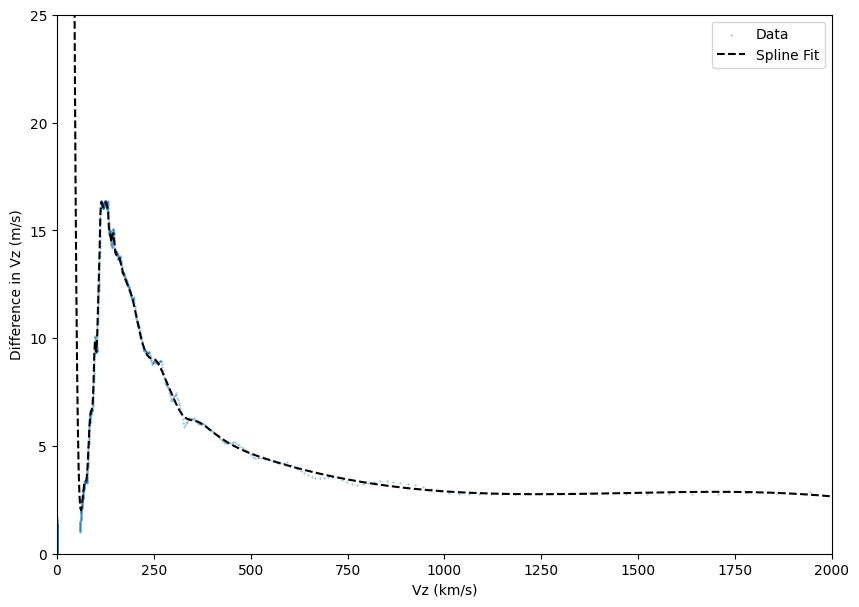

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def compensate_vz(Vz, vz_interpolated, smoothing_factor=1):
    """
    Compensate for the offset in the Vz value given by an interpolator.
    
    Parameters:
    -----------
    Vz : array-like
        Nominal Vz values.
    vz_interpolated : array-like
        Interpolated Vz values that have an offset error.
    smoothing_factor : float
        Smoothing factor for the UnivariateSpline fit. Adjust this to control 
        the balance between smoothness and fidelity to the data.
    
    Returns:
    --------
    corrected_vz : np.ndarray
        Corrected Vz values after subtracting the estimated offset.
    offset_spline : UnivariateSpline
        Spline function mapping nominal Vz to the offset correction.
    """
    # Flatten the arrays to 1D
    Vz_flat = Vz.flatten()
    
    # Compute the offset between the interpolated values and the nominal values.
    # (Here, nominal is assumed to be Vz/1000 based on your code.)
    offset = np.abs(vz_interpolated - Vz_flat/1000)
    
    # Define a mask for valid data points (adjust criteria as needed)
    mask = (
        np.isfinite(Vz_flat) & 
        np.isfinite(offset) & 
        (offset < 20) & 
        (offset > 2) & 
        (Vz_flat > 50) & 
        (Vz_flat < 2000)
    )
    
    # Get the valid x and y values for the spline fit
    x_valid = Vz_flat[mask]
    y_valid = offset[mask]
    
    # Sort the valid data (spline fitting is smoother if the x-data is sorted)
    sort_idx = np.argsort(x_valid)
    x_sorted = x_valid[sort_idx]
    y_sorted = y_valid[sort_idx]
    
    # Fit a Univariate Spline to the valid data
    offset_spline = UnivariateSpline(x_sorted, y_sorted, s=smoothing_factor)
    
    # Compute the offset for all nominal Vz values using the spline
    correction = offset_spline(Vz_flat)
    
    # Apply the correction to the interpolated Vz values.
    # (Here we subtract the estimated offset.)
    corrected_vz = vz_interpolated/ correction
    
    return corrected_vz, offset_spline

# =============================================================================
# Example usage:
# =============================================================================
# Assume Vz and vz_interpolated are already defined numpy arrays.

# Build the offset function and get corrected values
corrected_vz, offset_spline = compensate_vz(Vz, vz_interpolated, smoothing_factor=10)

# For visualization, create a dense set of x-values to evaluate the spline
x_plt = np.linspace(0, 2000, 1000)
y_plt = offset_spline(x_plt)

fig, ax = plt.subplots(figsize=(10, 7))
# Plot the original offset data points
ax.scatter(Vz.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000), 
           s=0.1, alpha=0.8, label="Data")
# Plot the spline fit
ax.plot(x_plt, y_plt, 'k--', label="Spline Fit")
#ax.vlines(50, 0, 25, color='r', alpha=0.5, label="Vz = 50")
ax.set_ylim(0, 25)
ax.set_xlim(0, 2000)
ax.set_ylabel('Difference in Vz (m/s)')
ax.set_xlabel('Vz (km/s)')
ax.legend()
plt.show()


Text(0.5, 0, 'Vz (km/s)')

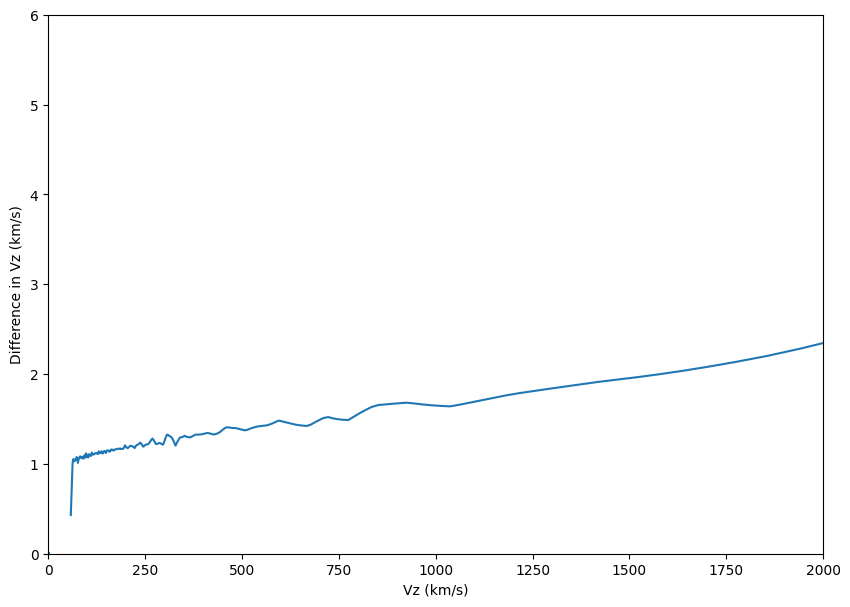

In [141]:
# after spline
fig, ax = plt.subplots(1,1, figsize = (10, 7))
#ax.scatter(Vz.flatten(), np.abs(corrected_vz - Vz.flatten()/1000) , s= 0.5, alpha = 1)
ax.plot(Vz.flatten(), np.abs(corrected_vz - Vz.flatten()/1000) )#, s= 0.5, alpha = 1)
ax.set_ylim(0, 6)
ax.set_xlim(0, 2000)
ax.set_ylabel('Difference in Vz (km/s)')
ax.set_xlabel('Vz (km/s)')


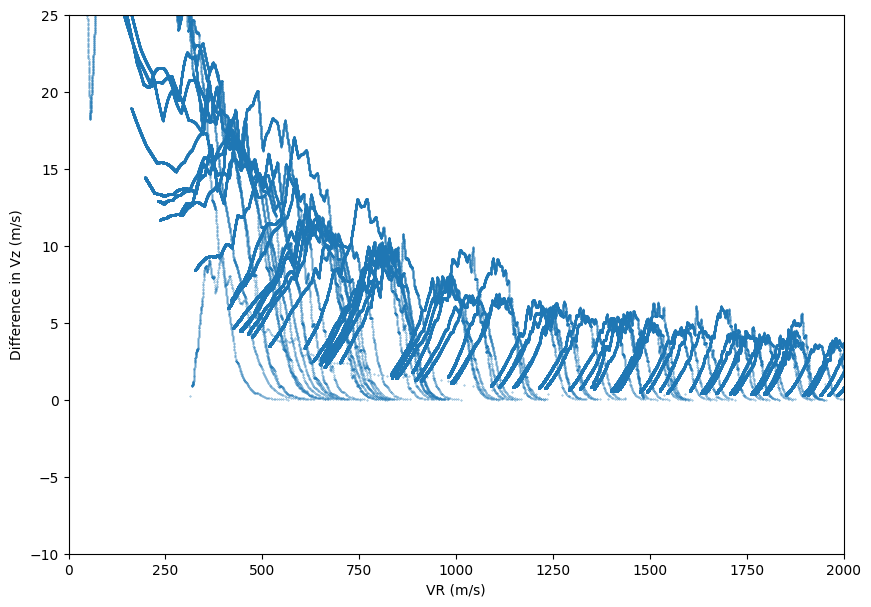

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10, 7))
ax.scatter(VR.flatten(), np.abs(vz_interpolated - Vz.flatten()/1000) , s= 0.1, alpha = 0.8)
ax.set_ylim(-10, 25)
#ax.plot([-2000, 2000], [0, 0], 'k--', alpha = 0.6)
ax.set_xlim(0, 2000)
#ax.set_yscale('symlog') 
ax.set_ylabel('Difference in Vz (m/s)')
ax.set_xlabel('VR (m/s)')
plt.show()

In [165]:
# save the orbits to a file
#data_gala_orbits = pd.DataFrame({'R': R.flatten(), 'z': z.flatten(), 'VR': VR.flatten(), 'Vz': Vz.flatten(), 'x': x.flatten(), 'y': y.flatten(), 'z': z.flatten(), 'vx': vx.flatten(), 'vy': vy.flatten(), 'vz': vz.flatten(), 'vz_interp': vz_interpolated.flatten()}).to_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/orbits/gala_ejections/orbits_small.csv', index=False)

KeyboardInterrupt: 

# Test different interpolators

In [153]:
from scipy.stats import binned_statistic_2d

xbins = 100  # bins in z/R
ybins = 100  # bins in log10(VR)

stat, xedges, yedges, binnum = binned_statistic_2d(
    y= z.flatten()/R.flatten(), # to avoid log(0) we add a small number
    x=np.log10(R.flatten()),
    values=Vz.flatten()/R.flatten()*VR.flatten(),
    statistic='mean',
    bins=[xbins, ybins]
)


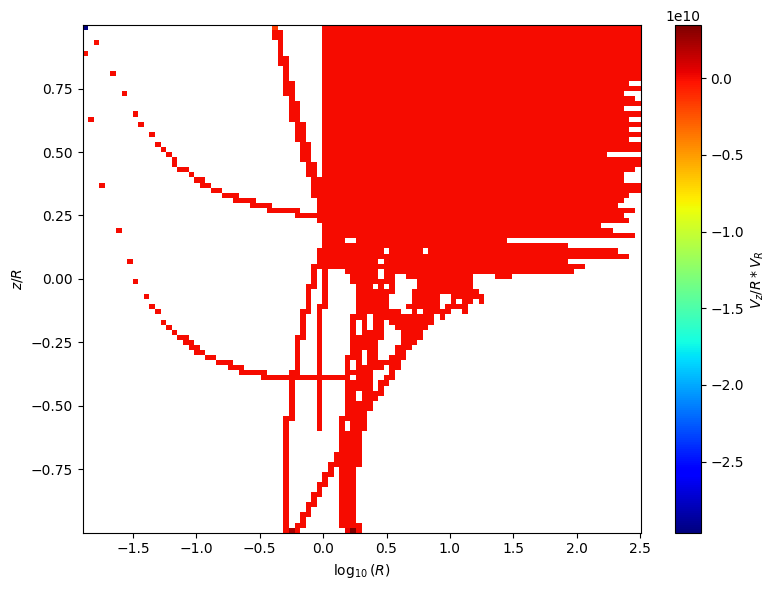

In [154]:
# Plot the 2D statistic 
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, stat.T, cmap='jet', shading='auto')

cb = plt.colorbar()
cb.set_label(r'$V_z/R*V_R$ ')

plt.xlabel(r'$\log_{10}(R)$')
plt.ylabel(r'$z/R$')
plt.tight_layout()
#plt.savefig('/Users/mncavieres/Documents/2024-2/HVS/Plots/interpolator/vz_rf_log10R_sergey.pdf', dpi = 300)
plt.show()

In [ ]:
Vz.flatten()/R.flatten()*VR.flatten(),